# Plot drift across sessions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import labdatatools as ldt
import spks
from pathlib import Path
from tqdm import tqdm
# we use spikeinterface for all things preprocessing and data handling now
import spikeinterface.full as si
import sys
sys.path.append('/home/joao/lib/dartsort/src/')
from dartsort.main import subtract
from dartsort.util.data_util import DARTsortSorting
# AP registration lives here for now
#from dredge.dredge_ap import register
# this has some helpers for plotting
#import dredge.motion_util as mu

# spikeinterface peak detection + localization
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 18})

c:\Users\mmelin\anaconda3\envs\spks\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## 1. Get the data from GDrive

In [3]:
SUBJECT = 'JC131'
#DATATYPE = 'kilosort2.5-motion-corrected'
DATATYPE = 'kilosort2.5'
DPATH = Path(r'X:/labdatatools_data/')

files = ldt.rclone_list_files(SUBJECT)
files.head()

ori_sessions = files[files.datatype == 'orientation'].session
ori_sessions = np.unique(ori_sessions).tolist()

temp = []
for sess in ori_sessions: # ensure that kilosort data exists
    if DATATYPE in files[files.session == sess].datatype.values:
        ses = files[files.session == sess].iloc[0].session
        temp.append(ses)
ori_sessions = np.array(temp)
print(len(ori_sessions))
    

71


In [4]:
ori_sessions = ori_sessions[:3] #truncate for testing

In [7]:
#TODO: get resorted data
for date in ori_sessions:
    ldt.rclone_get_data(subject=SUBJECT, session=date, datatype=DATATYPE, excludes=['**.bin','**.hdf']) #spike sorting
    ldt.rclone_get_data(subject=SUBJECT, session=date, includes=['**imec*.ap.meta'], excludes=['**.bin']) #meta files

rclone copy --progress globus:data/JC131/20230724_175348/kilosort2.5 X:/labdatatools_data\JC131\20230724_175348\kilosort2.5 --exclude "**.bin" --exclude "**.hdf" --ignore-existing


0it [00:02, ?it/s]


rclone copy --progress churchlanddata2:data/JC131/20230724_175348/kilosort2.5 X:/labdatatools_data\JC131\20230724_175348\kilosort2.5 --exclude "**.bin" --exclude "**.hdf" --ignore-existing


100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


rclone copy --progress globus:data/JC131/20230724_175348 X:/labdatatools_data\JC131\20230724_175348 --include "**imec*.ap.meta" --exclude "**.bin" --ignore-existing


1it [00:02,  2.17s/it]


rclone copy --progress churchlanddata2:data/JC131/20230724_175348 X:/labdatatools_data\JC131\20230724_175348 --include "**imec*.ap.meta" --exclude "**.bin" --ignore-existing


0it [00:01, ?it/s]


rclone copy --progress globus:data/JC131/20230725_211136/kilosort2.5 X:/labdatatools_data\JC131\20230725_211136\kilosort2.5 --exclude "**.bin" --exclude "**.hdf" --ignore-existing


0it [00:02, ?it/s]


rclone copy --progress churchlanddata2:data/JC131/20230725_211136/kilosort2.5 X:/labdatatools_data\JC131\20230725_211136\kilosort2.5 --exclude "**.bin" --exclude "**.hdf" --ignore-existing


100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


rclone copy --progress globus:data/JC131/20230725_211136 X:/labdatatools_data\JC131\20230725_211136 --include "**imec*.ap.meta" --exclude "**.bin" --ignore-existing


1it [00:02,  2.23s/it]


rclone copy --progress churchlanddata2:data/JC131/20230725_211136 X:/labdatatools_data\JC131\20230725_211136 --include "**imec*.ap.meta" --exclude "**.bin" --ignore-existing


0it [00:18, ?it/s]


rclone copy --progress globus:data/JC131/20230726_184457/kilosort2.5 X:/labdatatools_data\JC131\20230726_184457\kilosort2.5 --exclude "**.bin" --exclude "**.hdf" --ignore-existing


0it [00:02, ?it/s]


rclone copy --progress churchlanddata2:data/JC131/20230726_184457/kilosort2.5 X:/labdatatools_data\JC131\20230726_184457\kilosort2.5 --exclude "**.bin" --exclude "**.hdf" --ignore-existing


100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


rclone copy --progress globus:data/JC131/20230726_184457 X:/labdatatools_data\JC131\20230726_184457 --include "**imec*.ap.meta" --exclude "**.bin" --ignore-existing


1it [00:02,  2.41s/it]


rclone copy --progress churchlanddata2:data/JC131/20230726_184457 X:/labdatatools_data\JC131\20230726_184457 --include "**imec*.ap.meta" --exclude "**.bin" --ignore-existing


0it [00:01, ?it/s]


In [9]:
# need to drop sessions with a different channelmap
from spks import *

coords = None
keep_idx = []
metapaths = []
for i,date in enumerate(ori_sessions):
    metapath = Path(ldt.get_filepath(subject=SUBJECT, session=date, subfolders=['ephys_*','*'], filename='*imec*.ap.meta'))
    metapaths.append(metapath)
    meta = read_spikeglx_meta(metapath)
    if coords is None:
        coords = meta['coords']
    if np.array_equal(coords, meta['coords']):
        keep_idx.append(i)
    else:
        print(f'Dropping {ori_sessions[i]} due to different channelmap')

ori_sessions = ori_sessions[keep_idx]
    

## 2. Load spike positions, amplitudes, and depths

In [11]:
meta = read_spikeglx_meta(metapath)

{'acqApLfSy': '384,0,1',
 'appVersion': 20230411.0,
 'fileCreateTime': '2023-07-26T18:45:04',
 'fileName': 'D:/data/JC131/20230726_184457/ephys_g0/ephys_g0_imec0/ephys_g0_t0.imec0.ap.bin',
 'fileSHA1': 'FC65F9C8134246070D6D57AEE90630CABA644035',
 'fileSizeBytes': 22386482580.0,
 'fileTimeSecs': 969.1012709917699,
 'firstSample': 1621808.0,
 'gateMode': 'Immediate',
 'imAiRangeMax': 0.5,
 'imAiRangeMin': -0.5,
 'imAnyChanFullBand': 'true',
 'imCalibrated': 'true',
 'imChan0apGain': 80.0,
 'imDatApi': 3.6,
 'imDatBs_fw': '2.0.169',
 'imDatBsc_fw': '3.2.186',
 'imDatBsc_hw': 2.1,
 'imDatBsc_pn': 'NP2_QBSC_00',
 'imDatBsc_sn': 403.0,
 'imDatFx_hw': 1.8,
 'imDatFx_pn': 'NPM_FLEX_0',
 'imDatFx_sn': 0.0,
 'imDatHs_hw': 2.9,
 'imDatHs_pn': 'NPM_HS_30',
 'imDatHs_sn': 20470066.0,
 'imDatPrb_dock': 1.0,
 'imDatPrb_pn': 'NP2010',
 'imDatPrb_port': 4.0,
 'imDatPrb_slot': 4.0,
 'imDatPrb_sn': 20403312753.0,
 'imDatPrb_type': 24.0,
 'imIsSvyRun': 'false',
 'imLEDEnable': 'false',
 'imMaxInt': 8192.0

In [14]:
amps,depths,times = [],[],[]
fileoffset_seconds = 0 # no offset for first session
for i,(date,metapath) in enumerate(zip(ori_sessions,metapaths)):
    p = DPATH / SUBJECT / date / DATATYPE / 'imec0'
    print(p)
    clu = Clusters(p)
    #clu.load_waveforms()
    clu.compute_statistics(recompute=True)
    #not_noise  = (clu.cluster_info.active_channels)<40  #TODO: do something to throw out noise spikes?
    amps.extend(np.abs(clu.spike_amplitudes))
    depths.extend(clu.spike_positions[:,1])

    meta = read_spikeglx_meta(metapath)
    if i > 0:
        spike_times = clu.spike_times / meta['sRateHz'] + fileoffset_seconds
    else:
        spike_times = clu.spike_times / meta['sRateHz']
    times.extend(spike_times)
    fileoffset_seconds += meta['fileTimeSecs']


amps = np.stack(amps)
times = np.stack(times)
depths = np.stack(depths)

assert amps.shape == depths.shape == times.shape

X:\labdatatools_data\JC131\20230724_175348\kilosort2.5\imec0
[0] warning spike_pc_features does not have the same size as spike_amplitudes.
 
Spike depths will be based on the template position. Re-sort the dataset to fix X:\labdatatools_data\JC131\20230724_175348\kilosort2.5\imec0


[Clusters] Computing unit metrics: 0it [00:00, ?it/s]c:\data\churchland\spks\spks\metrics.py:105: RuntimeWarning: invalid value encountered in sqrt
  isi_contam  = 1 - np.sqrt(1-n_v*(T-2*N*censored_time)/(N**2*(refractory_time - censored_time)))
[Clusters] Computing unit metrics: 641it [00:01, 326.60it/s]
[Clusters] Computing waveform stats: 641it [00:00, 2447.05it/s]


X:\labdatatools_data\JC131\20230725_211136\kilosort2.5\imec0
[0] warning spike_pc_features does not have the same size as spike_amplitudes.
 
Spike depths will be based on the template position. Re-sort the dataset to fix X:\labdatatools_data\JC131\20230725_211136\kilosort2.5\imec0


[Clusters] Computing unit metrics: 0it [00:00, ?it/s]c:\data\churchland\spks\spks\metrics.py:105: RuntimeWarning: invalid value encountered in sqrt
  isi_contam  = 1 - np.sqrt(1-n_v*(T-2*N*censored_time)/(N**2*(refractory_time - censored_time)))
[Clusters] Computing unit metrics: 518it [00:01, 324.93it/s]
[Clusters] Computing waveform stats: 518it [00:00, 2440.97it/s]


X:\labdatatools_data\JC131\20230726_184457\kilosort2.5\imec0
[0] warning spike_pc_features does not have the same size as spike_amplitudes.
 
Spike depths will be based on the template position. Re-sort the dataset to fix X:\labdatatools_data\JC131\20230726_184457\kilosort2.5\imec0


[Clusters] Computing unit metrics: 0it [00:00, ?it/s]c:\data\churchland\spks\spks\metrics.py:105: RuntimeWarning: invalid value encountered in sqrt
  isi_contam  = 1 - np.sqrt(1-n_v*(T-2*N*censored_time)/(N**2*(refractory_time - censored_time)))
[Clusters] Computing unit metrics: 532it [00:01, 286.93it/s]
[Clusters] Computing waveform stats: 532it [00:00, 2462.24it/s]


## 3. Run motion estimation

In [15]:
from dredge.dredge_ap import register

motion_est, extra_info = register(amps, depths, times)

Cross correlation:   0%|          | 0/8 [00:00<?, ?it/s]

Solve:   0%|          | 0/7 [00:00<?, ?it/s]

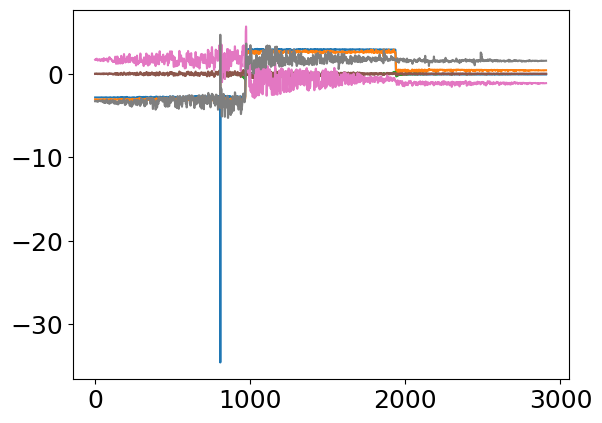

In [16]:
import matplotlib.pyplot as plt
plt.plot(motion_est.displacement.T)